In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import *
import os
from matplotlib.ticker import StrMethodFormatter
import scipy
from pathos.multiprocessing import ProcessingPool as Pool

import sys
from IPython.display import clear_output

import DarkNews
from DarkNews import const 
from analysis_dn import fit_functions as ff
from analysis_dn import hist_plot
from DarkNews.GenLauncher import GenLauncher
from analysis_dn import analysis as a
from analysis_dn import analysis_decay as a_d
from analysis_dn import decayer

# 1. Set general parameters for fitting

### Path and Grid

In [3]:
epsilon = 1e-4
epsilon_s = '1e-4'

# PATH
path = f'results/3p2_general_m4_0.05_e_{epsilon_s}/'
path_data = path+'chi2_fit_3p2.dat'

# Number of processors
workers = 8

# Grid parameters
points = 30
m4 = 0.05
mzprime = np.geomspace(0.01, 2.0, points)
m5 = np.geomspace(0.055, 2.0, points)
m5=ff.round_sig(m5,4)
mzprime=ff.round_sig(mzprime,4)

### Parameters for simulation

In [4]:
ud4_def = 1.0/np.sqrt(2.)
ud5_def = 1.0/np.sqrt(2.)
gD_def = 2.
umu4_def = np.sqrt(1.0e-12)
umu5_def = np.sqrt(1.0e-12)
epsilon_def = 1e-4

v54 = gD_def * ud5_def * ud4_def
vmu5_def = gD_def * ud5_def * (umu4_def*ud4_def + umu5_def*ud5_def) / np.sqrt(1 - umu4_def**2 - umu5_def**2)


def vmu5_f(umu4,umu5):
    return gD_def * ud5_def * (umu4*ud4_def + umu5*ud5_def) / np.sqrt(1 - umu4**2 - umu5**2)

r_eps = epsilon / epsilon_def


vmui_max = 1e-3
v_cut = vmu5_f(vmui_max,vmui_max)

### Data from MiniBooNE

In [5]:
data_MB_enu = hist_plot.get_data_MB(varplot='reco_Enu',loc='../')
back_MC_enu = data_MB_enu[1]
D_enu = data_MB_enu[0] + data_MB_enu[1]
sys_enu = [data_MB_enu[2], data_MB_enu[3]]

### Data for distributions

In [6]:
cols=['mzprime','m5','m4','delta','sum_w_post_smearing','v_mu5','v_54','epsilon','u_mu5/u_mu4','chi2','decay_length','N_events','scatt_det']
bin_e = np.array([0.2, 0.3, 0.375, 0.475, 0.55, 0.675, 0.8, 0.95, 1.1, 1.3, 1.5, 3.])

# 2. Plot the results

### Load the plotting libraries

In [7]:
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib import ticker

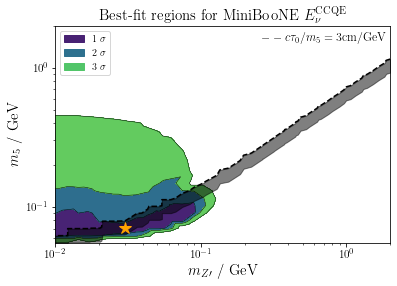

<Figure size 432x288 with 0 Axes>

In [9]:
# general features
save = True
extension = 'jpg'
leg_loc = 'upper left'

# data names and titles
path_data = path+'chi2_fit_3p2.dat'
plot_path = path +f'plots/fit_3p2_general_m4_{m4}_e_e-4.' + extension
data = pd.read_csv(path_data,sep='\t')

data = data[data.chi2 >= 0]

plot_title = r'Best-fit regions for MiniBooNE $E_\nu^{\mathrm{CCQE}}$'
ylabel = r'$m_5 \ / $ GeV'
xlabel = r'$m_{Z \prime} \ / $ GeV'
    
# load data for each parameter
Y = data['m5'].values
X = data['mzprime'].values

# line divisions for other possible channels
Y_1 = np.ones(len(Y))
Y_2 = 2 * Y_1
X_0 = np.linspace(X.min(),X.max(),500)
Y_1 = np.ones(len(X_0))
Y_2 = 2 * Y_1

# What to plot
Z = data['chi2'].values
Z -= Z.min()
dec = data['decay_length'].values / data['m5'].values

# Minimum
marker = '*'
mask = Z == Z.min()
xmin_enu, ymin_enu = X[mask][0],Y[mask][0]

# Colors
num_colors = 12
viridis = cm.get_cmap('viridis', num_colors)
bar_1 = mpatches.Patch(color=viridis(range(num_colors))[1], label=r'1 $\sigma$')
bar_2 = mpatches.Patch(color=viridis(range(num_colors))[4], label=r'2 $\sigma$')
bar_3 = mpatches.Patch(color=viridis(range(num_colors))[8], label=r'3 $\sigma$')
bar_4 = mpatches.Patch(color="gray", label=r'$c \tau_0 / m_5 = 1 \mathrm{cm / GeV}$')

# Plot
plt.rcParams["figure.figsize"] = (6,4)
levels = [0,2.3,6.18,11.83]
level_dif = [1.25]
plt.tricontourf(X,Y,Z,levels=levels,cmap='viridis')
plt.tricontour(X,Y,Z,levels=levels,colors='black',linewidths=0.5)

# Plot ctau = 1 cm/GeV
cs = plt.tricontour(X,Y,dec,levels=[3.],colors='black',linewidths=1.5,linestyles='dashed')
a = cs.collections[0].get_paths()[0]
xline, yline = a.vertices.T
plt.fill_between(xline,0.8*yline,yline,color="black",alpha=0.5)

# Regime channels
#plt.text(0.6,1.1,r'$N_5 \rightarrow N_4 N_4 \nu_i$',color='black',size=11)
#plt.text(0.6,2.2,r'$N_5 \rightarrow N_4 N_4 N_4$',color='black',size=11)

# Plot minimum and regimes
plt.plot(xmin_enu,ymin_enu,color='orange',marker=marker,markersize=12)
#plt.plot(X_0,Y_1,color="gray",linewidth=1,linestyle="dotted")
#plt.plot(X_0,Y_2,color="gray",linewidth=1,linestyle="dotted")
#plt.fill_between(X_0,1,2,color="gray",alpha=0.2)
#plt.fill_between(X_0,2,Y.max(),color="gray",alpha=0.4)
plt.text(0.26,1.55,r'$--c \tau_0 / m_5 = 3 \mathrm{cm / GeV}$',color='black',size=12)


plt.legend(handles=[bar_1, bar_2, bar_3],fontsize=10,loc=leg_loc)
plt.title(plot_title,fontsize=15)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel,fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim(X.min(),X.max())
plt.ylim(Y.min(),Y.max())
if save:
    plt.savefig(plot_path,dpi=400)
    plt.show()
else:
    plt.show()
plt.clf()

In [9]:
0.000475**2

2.25625e-07

In [8]:
path_data = path+'chi2_fit_3p2.dat'
data = pd.read_csv(path_data,sep='\t')
data = data[data.chi2 >= 0]
data[data.chi2 == data.chi2.min()]

,mzprime,m5,m4,delta,sum_w_post_smearing,v_mu5,v_54,epsilon,u_mu5/u_mu4,chi2,decay_length,N_events
42,0.029928,0.070468,0.05,0.40937,0.00978,0.000475,1.0,0.0001,0.000238,6.187922,8.298403,552.614645


## Minimum

In [10]:
print(xmin_enu,ymin_enu)

0.0299278260897084 0.0704684822080478


In [11]:
from matplotlib import ticker
from matplotlib.ticker import StrMethodFormatter

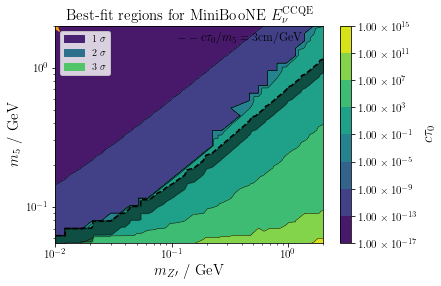

<Figure size 432x288 with 0 Axes>

In [13]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

#general features
save = True
extension = 'jpg'
leg_loc = 'upper left'

# data names and titles
path_data = path+'chi2_fit_3p2.dat'
plot_path = path +f'plots/fit_3p2_general_m4_{m4}_e_e-4_lifetimes.' + extension
data = pd.read_csv(path_data,sep='\t')

data = data[data.chi2 >= 0]

plot_title = r'Best-fit regions for MiniBooNE $E_\nu^{\mathrm{CCQE}}$'
ylabel = r'$m_5 \ / $ GeV'
xlabel = r'$m_{Z \prime} \ / $ GeV'
    
# load data for each parameter
Y = data['m5'].values
X = data['mzprime'].values

# line divisions for other possible channels
Y_1 = np.ones(len(Y))
Y_2 = 2 * Y_1
X_0 = np.linspace(X.min(),X.max(),500)
Y_1 = np.ones(len(X_0))
Y_2 = 2 * Y_1

# What to plot
Z = data['decay_length'].values
dec = data['decay_length'].values / data['m5'].values

# Minimum
marker = '*'
mask = Z == Z.min()
xmin_enu, ymin_enu = X[mask][0],Y[mask][0]

# Plot
plt.rcParams["figure.figsize"] = (6,4)
levels = 10
level_dif = [1.25]
t = plt.tricontourf(X,Y,Z,levels=levels,locator=ticker.LogLocator(),cmap='viridis')
plt.tricontour(X,Y,Z,levels=levels,locator=ticker.LogLocator(),colors='black',linewidths=0.5)
cbar = plt.colorbar(t, format=ticker.FuncFormatter(fmt))
cbar.set_label(r'$c\tau_0$',size=15)


# Plot ctau = 1 cm/GeV
cs = plt.tricontour(X,Y,dec,levels=[3.],colors='black',linewidths=1.5,linestyles='dashed')
a = cs.collections[0].get_paths()[0]
xline, yline = a.vertices.T
plt.fill_between(xline,0.8*yline,yline,color="black",alpha=0.5)

# Regime channels
#plt.text(0.6,1.1,r'$N_5 \rightarrow N_4 N_4 \nu_i$',color='black',size=11)
#plt.text(0.6,2.2,r'$N_5 \rightarrow N_4 N_4 N_4$',color='black',size=11)

# Plot minimum and regimes
plt.plot(xmin_enu,ymin_enu,color='orange',marker=marker,markersize=12)
#plt.plot(X_0,Y_1,color="gray",linewidth=1,linestyle="dotted")
#plt.plot(X_0,Y_2,color="gray",linewidth=1,linestyle="dotted")
#plt.fill_between(X_0,1,2,color="gray",alpha=0.2)
#plt.fill_between(X_0,2,Y.max(),color="gray",alpha=0.4)
plt.text(0.11,1.55,r'$--c \tau_0 / m_5 = 3 \mathrm{cm / GeV}$',color='black',size=12)


plt.legend(handles=[bar_1, bar_2, bar_3],fontsize=10,loc=leg_loc)
plt.title(plot_title,fontsize=15)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel,fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim(X.min(),X.max())
plt.ylim(Y.min(),Y.max())
if save:
    plt.savefig(plot_path,dpi=400)
    plt.show()
else:
    plt.show()
plt.clf()

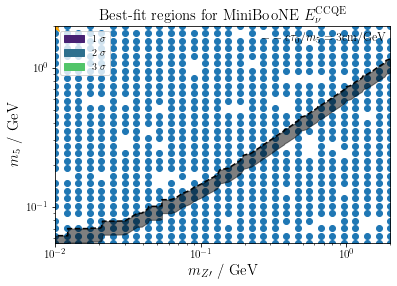

<Figure size 432x288 with 0 Axes>

In [14]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

#general features
save = True
extension = 'pdf'
leg_loc = 'upper left'

# data names and titles
path_data = path+'chi2_fit_3p2.dat'
plot_path = path +f'plots/fit_3p2_general_m4_{m4}_e_e-4_lifetimes_scatter.' + extension
data = pd.read_csv(path_data,sep='\t')

data = data[data.chi2 >= 0]

plot_title = r'Best-fit regions for MiniBooNE $E_\nu^{\mathrm{CCQE}}$'
ylabel = r'$m_5 \ / $ GeV'
xlabel = r'$m_{Z \prime} \ / $ GeV'
    
# load data for each parameter
Y = data['m5'].values
X = data['mzprime'].values

# line divisions for other possible channels
Y_1 = np.ones(len(Y))
Y_2 = 2 * Y_1
X_0 = np.linspace(X.min(),X.max(),500)
Y_1 = np.ones(len(X_0))
Y_2 = 2 * Y_1

# What to plot
Z = data['decay_length'].values
Z -= Z.min()
dec = data['decay_length'].values / data['m5'].values

# Minimum
marker = '*'
mask = Z == Z.min()
xmin_enu, ymin_enu = X[mask][0],Y[mask][0]

# Plot
plt.rcParams["figure.figsize"] = (6,4)
levels = 10
level_dif = [1.25]
#t = plt.scatter(X,Y,c=np.log(Z))
t = plt.scatter(X,Y)
#cbar = plt.colorbar(t, format=ticker.FuncFormatter(fmt))
#cbar.set_label(r'$c\tau_0$',size=15)


# Plot ctau = 1 cm/GeV
cs = plt.tricontour(X,Y,dec,levels=[3.],colors='black',linewidths=1.5,linestyles='dashed')
a = cs.collections[0].get_paths()[0]
xline, yline = a.vertices.T
plt.fill_between(xline,0.8*yline,yline,color="black",alpha=0.5)

# Regime channels
#plt.text(0.6,1.1,r'$N_5 \rightarrow N_4 N_4 \nu_i$',color='black',size=11)
#plt.text(0.6,2.2,r'$N_5 \rightarrow N_4 N_4 N_4$',color='black',size=11)

# Plot minimum and regimes
plt.plot(xmin_enu,ymin_enu,color='orange',marker=marker,markersize=12)
#plt.plot(X_0,Y_1,color="gray",linewidth=1,linestyle="dotted")
#plt.plot(X_0,Y_2,color="gray",linewidth=1,linestyle="dotted")
#plt.fill_between(X_0,1,2,color="gray",alpha=0.2)
#plt.fill_between(X_0,2,Y.max(),color="gray",alpha=0.4)
plt.text(0.26,1.55,r'$--c \tau_0 / m_5 = 3 \mathrm{cm / GeV}$',color='black',size=12)


plt.legend(handles=[bar_1, bar_2, bar_3],fontsize=10,loc=leg_loc)
plt.title(plot_title,fontsize=15)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel,fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.xlim(X.min(),X.max())
plt.ylim(Y.min(),Y.max())
if save:
    plt.savefig(plot_path,dpi=400)
    plt.show()
else:
    plt.show()
plt.clf()

In [18]:
len(data)

839

In [19]:
len(np.sort(data['m5'].unique()))

30